# Running Data Analysis
## Isaac Burmingham
##### Advisor: Dr. Kirk Anne

In [923]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats.stats import pearsonr
import folium
from folium import features
import datetime
import time
%matplotlib inline

Running Data was extracted from my personal Garmin watch which contains over two years worth of running data. I typically sync my runs with Strava, since it provides more insightful analysis of my runs and a better aesthetic. Also, Strava has a fairly easy data extraction, which contains all .gz files, which are the outputs of the watch during each run. This allowed for a large quantity of data to be extracted. A different file was written in order to convert the data the a readable csv which will also be posted on my github.

In [2]:
allfitdf = pd.read_csv("/Users/Isaac/DS Running/AllFITdf.csv")
metadf = pd.read_csv("/Users/Isaac/DS Running/activities.csv")
garmindf = pd.read_csv("/Users/Isaac/DS Running/Updated_Activities.csv")

In [3]:
avgallfitdf = allfitdf.groupby(['filename']).mean()
#avgallfitdf.head()

In [4]:
allfitdf['latitude'] = allfitdf['position_lat']*180/pow(2,31)
allfitdf['longitude'] = allfitdf['position_long']*180/pow(2,31)

In [5]:
allfitdf["DateTime"] = pd.to_datetime(allfitdf["timestamp"]).apply(lambda x:x.date())
allfitdf["TimeOfDay"] = pd.to_datetime(allfitdf["timestamp"]).apply(lambda x:x.time())
allfitdf["WeekYear"] = pd.to_datetime(allfitdf["timestamp"]).apply(lambda x:x.week + x.year*100)
allfitdf["Year"] = pd.to_datetime(allfitdf["timestamp"]).apply(lambda x:x.year)
allfitdf["Week"] = pd.to_datetime(allfitdf["timestamp"]).apply(lambda x:x.week)
allfitdf["Month"] = pd.to_datetime(allfitdf["timestamp"]).apply(lambda x:x.month)
allfitdf["Day"] = pd.to_datetime(allfitdf["timestamp"]).apply(lambda x:x.day)
allfitdf["IsoCalendar"]=pd.to_datetime(allfitdf["timestamp"]).apply(lambda x:x.isocalendar())

In [6]:
allfitdf["season"]= ""
allfitdf.loc[allfitdf['Month'].isin([12,1,2]),"season"] = 'Winter'
allfitdf.loc[allfitdf['Month'].isin([3,4,5]),"season"] = 'Spring'
allfitdf.loc[allfitdf['Month'].isin([6,7,8]),"season"] = 'Summer'
allfitdf.loc[allfitdf['Month'].isin([9,10,11]),"season"] = 'Fall'

In [8]:
metafilelist = metadf['Filename'].astype('str').apply(lambda x: x.split('/'))
metafilelist = metafilelist.to_list()

In [9]:
metafilelist[0][1]

'1948436429.fit.gz'

In [10]:
L = []
for item in metafilelist[::]:
    L.append(item[:][-1:])
    

In [11]:
filename = [item for sublist in L for item in sublist]

In [12]:
metadf['file'] = filename

In [13]:
metamerge = pd.merge(metadf,allfitdf,left_on='file',right_on='filename')

In [175]:
metamerge1 = metamerge[metamerge['Activity Name'] != 'Afternoon Ride']
metamerge2 = metamerge1[metamerge1['Activity Name'] != 'Morning Ride']
metamerge3 = metamerge2[metamerge2['Activity Name'] != 'Afternoon Activity']
metamerge4 = metamerge3[metamerge3['Activity Name'] != 'Evening Activity']
metamerge5 = metamerge4[metamerge4['Activity Name'] != 'Lunch Ride']
metamerge6 = metamerge5[metamerge5['Activity Type'] != 'Hike']
metamerge7 = metamerge6[metamerge6['Activity Type'] != 'Ride']


rundf = metamerge7[metamerge7['Activity Name'] != 'Evening Ride']



In [176]:
rundf = rundf.drop(['Commute','Activity Gear','unknown_88','Free memory','Sample rate','Activity Description',
            'Stroke Rate','Filename','heading'],axis=1)

# Indepedence Test of Heart Rate and Season

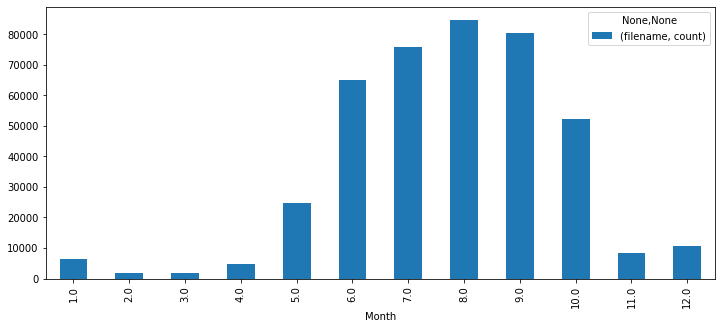

In [177]:
allfitdf.groupby(by=rundf.Month).agg({"filename":['count']}).plot(kind='bar',figsize=(12,5))

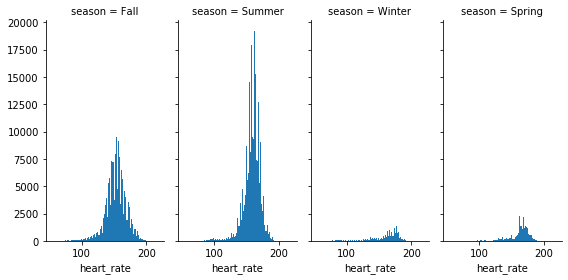

In [178]:
bins=100
g = sns.FacetGrid(rundf, col="season", height=4, aspect=0.5)
g = g.map(plt.hist, "heart_rate",bins=bins)

Obviously, there is much for data for Summer and Fall then there is due to injury in Winter and Spring. 

In [179]:
rundf.season.value_counts()

Summer    225776
Fall      141212
Spring     31346
Winter     18794
Name: season, dtype: int64

producing a contingency table for test.
<br> Null Hypothesis: Season and Heart Rate are independent
<br> Alternative Hypothesis: Season and Heart Rate are dependent

In [180]:
rundf = rundf.copy()
def bin_hr(df):
    cut_points = [45,99,139,159,179,200]
    label_names = ["45-99","100-139","140-159","160-179","180-200"]
    
    rundf["binnedHR"] = pd.cut(rundf["heart_rate"],cut_points,labels=label_names)
    return df

binned_HR = bin_hr(rundf)

In [181]:
seasonHRcont = pd.crosstab(rundf['season'],rundf['binnedHR'])
seasonHRcont

binnedHR,45-99,100-139,140-159,160-179,180-200
season,,,,,
Fall,1045,20825,73870,39789,5616
Spring,344,2970,4760,21085,2187
Summer,1499,12138,98268,108132,5739
Winter,1032,2289,3200,10082,2191


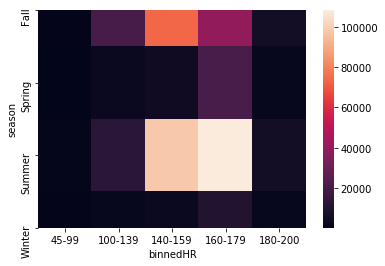

In [182]:
sns.heatmap(seasonHRcont)

In [183]:
f_obs = np.array([seasonHRcont.iloc[0][:].values, seasonHRcont.iloc[1][:].values,seasonHRcont.iloc[2][:].values,seasonHRcont.iloc[3][:].values])
                  

In [184]:
stats.chi2_contingency(f_obs)[0:3]

(42478.28303567446, 0.0, 12)

# ANOVA Test of Season and Heart Rate

In [185]:
rundf.heart_rate.mean()

156.89611102587216

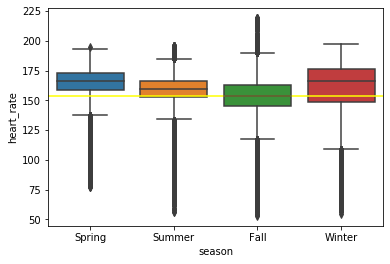

In [186]:
sns.boxplot(x='season',y='heart_rate',data=rundf,order=['Spring','Summer','Fall','Winter'])
plt.axhline(153.4,c='yellow')

In [187]:
mod = ols('heart_rate ~ season',data=rundf).fit()
anov_tab = sm.stats.anova_lm(mod,typ=2)
anov_tab.rename(columns={'PR(>F)':'p-value (>F)'})

,sum_sq,df,F,p-value (>F)
season,3.471377e+06,3.0,5203.223299,0.0
Residual,9.276266e+07,417124.0,NaN,NaN


Since the p-value is equal to 0, this tells us that at least one comparison is significantly different. So, we want to figure out which comparisons are and aren't. To do this, we must run a post-hoc analysis.

### ANOVA Post-hoc Analysis

In [188]:
pair_t = mod.t_test_pairwise('season',method = 'bonferroni')
pairtdf = pair_t.result_frame
pairtdf

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-bonferroni,reject-bonferroni
Spring-Fall,9.256308,0.093110,99.412988,0.000000e+00,9.073816,9.438800,0.000000e+00,True
Summer-Fall,5.200469,0.050595,102.786774,0.000000e+00,5.101305,5.299633,0.000000e+00,True
Winter-Fall,5.540193,0.115792,47.846283,0.000000e+00,5.313246,5.767141,0.000000e+00,True
Summer-Spring,-4.055840,0.089886,-45.121873,0.000000e+00,-4.232014,-3.879665,0.000000e+00,True
Winter-Spring,-3.716115,0.137577,-27.011185,1.503338e-160,-3.985761,-3.446468,9.020028e-160,True
Winter-Summer,0.339725,0.113216,3.000684,2.693901e-03,0.117825,0.561624,1.616341e-02,True


In [189]:
1-(1-0.05)**5

0.22621906250000023

In [190]:
0.05/5

0.01

In [191]:
1-(1-0.01)**5

0.04900995010000009

All season comparisons reject the null hypothesis. This seems to imply some strong dependence between season and heart rate. Although, the sample taken in each season was not constant. Different fitness levels can affect heart rate, and sample sizes were not the same due to injury in the fall and winter.

In [192]:
rundf.groupby(by='filename').agg({'TimeOfDay':['count']})

,TimeOfDay
,count
filename,
1948436385.fit.gz,189
1948436386.fit.gz,281
1948436387.fit.gz,219
1948436391.fit.gz,182
1948436395.fit.gz,552
...,...
2949408838.fit.gz,714
2952849700.fit.gz,3434


# Path Analysis

Using the latitudes and longitudes, the paths of each run could be extracted, analyzed, and plotted with Folium.

In [193]:
coords = [tuple([x,y]) for x,y in zip(rundf.loc[rundf.filename == '1948436385.fit.gz','latitude'].tolist(),rundf.loc[rundf.filename == '1948436385.fit.gz','longitude'].tolist()) if str(x) != 'nan']

In [194]:
def softmax(x):
    expo = np.exp(x)
    expo_sum = np.sum(expo)
    return expo/expo_sum

In [588]:
def color(x):
    L = []
    #d = x.describe()
    for k in x.to_list():
        if k < 139:
            L.append(1)
        if 140 <= k < 159:
            L.append(3)
        if 160 <= k < 179:
            L.append(6)
        if 180 <= k:
            L.append(10)
    return L

In [489]:
def colort(x):
    for k in [x]:
        if k < 139:
            return 1
        if 140 <= k < 159:
            return 3
        if 160 <= k < 179:
            return 6
        if 180 <= k:
            return 10
    return None

The above color functions are used in order to map specific heart rate values to colors corresponding on the ColorLine in Folium. I used the conventional heart rate regions for my maximum heart rate.

In [364]:
d = rundf.heart_rate.describe()
rundf['level'] = rundf['heart_rate'].apply(lambda x: colort(x))

In [365]:
levels = rundf.groupby(by='filename').agg({'level':['mean']})
#x[(x > 6) & (x < 7)].dropna()

In [376]:
levels.columns = [' '.join(col).strip() for col in levels.columns.values]

In [377]:
levels.reset_index(inplace=True)

Maximum efforts are races, regardless of elevation

In [378]:
levelcut = levels.where(levels['level mean'] >= 3)
levelcut

,filename,level mean
0,1948436385.fit.gz,5.043478
1,1948436386.fit.gz,4.699248
2,1948436387.fit.gz,5.644231
3,1948436391.fit.gz,5.724138
4,1948436395.fit.gz,7.322642
...,...,...
327,2949408838.fit.gz,3.940341
328,2952849700.fit.gz,5.134828
329,2957734612.fit.gz,3.496589
330,2961007483.fit.gz,3.834994


In [422]:
levelcut = levelcut.dropna().sort_values('level mean',ascending=True)

In [447]:
levelcutt= levelcut.groupby(by='filename').agg({'level mean':['mean']})

In [455]:
levelcutt = levelcutt.sort_values(by=('level mean','mean'))

In [714]:
m = folium.Map(location=[42.8, -77.8])
#[(x > 4) & (x < 5)]
for f in levelcutt.dropna().index[3:4]:
    tempdf = rundf.loc[(rundf.filename == f)]
    tempdf = tempdf.iloc[1:,:]
    
    coords = [tuple([x,y]) for x,y in zip(tempdf['latitude'].tolist(),tempdf['longitude'].tolist()) if str(x) != 'nan']

    colors = color(tempdf.heart_rate)
    
    sw = tempdf[['latitude', 'longitude']].min().values.tolist()
    ne = tempdf[['latitude', 'longitude']].max().values.tolist()
    
    avg = np.sum(colors)/len(tempdf.heart_rate)
    #print(avg)
    
    if not coords:
        continue
    color_line = features.ColorLine(
    positions=coords,
    colors=colors,
    weight=3)
    
    m.fit_bounds([sw, ne]) 

    color_line.add_to(m)

m

The first 5 or so smallest level runs are those which follow a similar path. This path is characteristic of post workout cool downs which would be significantly slower, and pre workout warm ups. Although, there are some that are actual runs that follow this path and have the smallest values

printing tempdf yields which activity is mapped and the data associated. Activity ID is then copy/pasted in order to perserve the data

I conclude that '2762446327' is the lowest level value that is an actual aerobic run, since the other lower values are pre-workout warm ups or post-workout cool downs. This workout has a relatively low elevation gain and was also a day for a race. It might be interesting to find the weather data for this day

In [502]:
lowlevel = rundf[rundf['Activity ID'] == 2762446327]

Now let's analyze the highest level run, excluding races and track workouts, and compare paths

In [929]:
m = folium.Map(location=[42.8, -77.8])
#[(x > 4) & (x < 5)]
for f in levelcutt.dropna().index[-10:-9]:
    tempdf = rundf.loc[(rundf.filename == f)]
    tempdf = tempdf.iloc[1:,:]
    
    coords = [tuple([x,y]) for x,y in zip(tempdf['latitude'].tolist(),tempdf['longitude'].tolist()) if str(x) != 'nan']

    sw = tempdf[['latitude', 'longitude']].min().values.tolist()
    ne = tempdf[['latitude', 'longitude']].max().values.tolist()
    
    colors = color(tempdf.heart_rate)
    
    avg = np.sum(colors)/len(tempdf.heart_rate)
    #print(avg)
    
    if not coords:
        continue
    color_line = features.ColorLine(
    positions=coords,
    colors=colors,
    weight=3)
    
    m.fit_bounds([sw, ne]) 
    
    color_line.add_to(m)

m

In [531]:
highlevel = rundf[rundf['Activity ID'] == 2103158663]

In [567]:
highlevel = highlevel.copy()
highlevel['actualDistance'] = highlevel['distance'].values[-1] * 0.0006213712
lowlevel = lowlevel.copy()
lowlevel['actualDistance'] = lowlevel['distance'].values[-1] * 0.0006213712

In [586]:
lowlevel.altitude.max() - lowlevel.altitude.min()

554.0

In [587]:
highlevel.altitude.max() - highlevel.altitude.min()

437.0

Interestingly, the change in elevation of the easy run was higher than that of the harder run. Although, based on my knowledge of the runs themselves, I would definitely say highlevel has more hills than lowlevel.

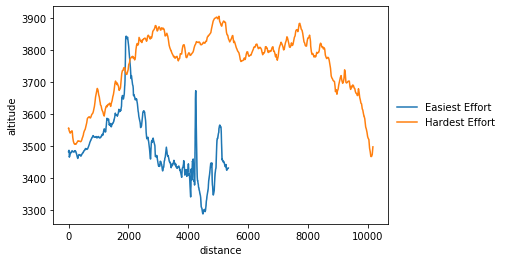

In [928]:
sns.lineplot(x='distance',y='altitude',data=lowlevel,label='Easiest Effort')
sns.lineplot(x='distance',y='altitude',data=highlevel,label='Hardest Effort')
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 10})
plt.show()

Comparing paths based on heart rate is difficult since fitness was different at each time. I know that for the highlevel data, it was right when I was getting back into running after an injury so I was out of shape. The lower rated run was when I was in peak condition, and it was a run right before a race so I tried to take it especially easy. With this in mind, I think it would be hard to draw conclusions from this analysis, since there are so many dependent variables involved. Instead, analyzing races might be more beneficial.

## Race Analysis

In [711]:
m = folium.Map(location=[43.073792,  -78.019684])
#[(x > 4) & (x < 5)]
for f in levelcutt.dropna().index[-3:-2]:
    tempdf = rundf.loc[(rundf.filename == f)]
    tempdf = tempdf.iloc[1:,:]
    
    coords = [tuple([x,y]) for x,y in zip(tempdf['latitude'].tolist(),tempdf['longitude'].tolist()) if str(x) != 'nan']

    colors = color(tempdf.heart_rate)
    
    sw = tempdf[['latitude', 'longitude']].min().values.tolist()
    ne = tempdf[['latitude', 'longitude']].max().values.tolist()
    
    avg = np.sum(colors)/len(tempdf.heart_rate)
    #print(avg)
    
    if not coords:
        continue
    color_line = features.ColorLine(
    positions=coords,
    colors=colors,
    weight=3)

    m.fit_bounds([sw, ne]) 

    color_line.add_to(m)

m

In [599]:
bergen = rundf.loc[rundf['Activity ID'] == 2607013494]

In [716]:
m = folium.Map(location=[43.3345138, -75.747964])
#[(x > 4) & (x < 5)]
for f in levelcutt.dropna():
    tempdf = rundf.loc[(rundf.filename == '2929987460.fit.gz')]
    tempdf = tempdf.iloc[1:,:]
    
    coords = [tuple([x,y]) for x,y in zip(tempdf['latitude'].tolist(),tempdf['longitude'].tolist()) if str(x) != 'nan']
    
    sw = tempdf[['latitude', 'longitude']].min().values.tolist()
    ne = tempdf[['latitude', 'longitude']].max().values.tolist()
    
    colors = color(tempdf.heart_rate)
    
    avg = np.sum(colors)/len(tempdf.heart_rate)
    #print(avg)
    
    if not coords:
        continue
    color_line = features.ColorLine(
    positions=coords,
    colors=colors,
    weight=3)
    
    m.fit_bounds([sw, ne]) 
    
    color_line.add_to(m)

m

In [615]:
copperwire = rundf[rundf['Activity ID'] == 2764779931]

The first race was the Bergen Elite 5k, which I ran 17:58. The second race was the Copper Wire 5k, in which I won the race in 17:34. The races were roughly 2 months apart

In [620]:
copperwire['altitude'].max() - copperwire['altitude'].min()

221.0

In [621]:
bergen['altitude'].max() - bergen['altitude'].min()

160.0

Bergen was more flat than the copper wire, but I did better at the copper wire due to a higher fitness level. The following is an elevation plot, but since Bergen was outside of Rochester and Copper Wire was in Camden NY, they are at different altitudes thus I took the difference between altitudes of the first point and added it to each altitude of the Copper Wire data, so that they overlayed better.

In [733]:
copperwire.reset_index(inplace=True)
bergen.reset_index(inplace=True)

In [735]:
bergen.altitude[0] - copperwire.altitude[0]

222.0

In [737]:
copperwire = copperwire.copy()
copperwire['altadj'] = copperwire.altitude + 222.0

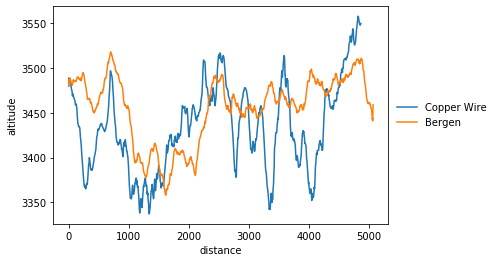

In [738]:
sns.lineplot(x='distance',y='altadj',label='Copper Wire',data=copperwire)
sns.lineplot(x='distance',y='altitude',label='Bergen',data=bergen)
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 10})
plt.show()

Both races are relatively flat (150 ft in change isn't that much) but it is true that Copper Wire is has more hills than Bergen. I raced better at CW due to my fitness level.

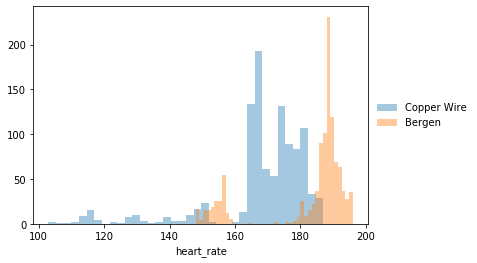

In [927]:
x = sns.distplot(copperwire['heart_rate'],label='Copper Wire',kde=False)
y = sns.distplot(bergen['heart_rate'],label='Bergen',kde=False)
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 10})
plt.show()

Evidently, my heart rate distribution for CW (blue) was more dispursed, and lower, despite hills. 

In [644]:
bergen.cadence.mean() * 2

166.88686131386862

In [643]:
copperwire.cadence.mean() * 2

166.02464454976302

Also interestingly, my cadence for the Copper Wire and Bergen were relatively the same, with Bergen being slightly quicker. If you are unfamiliar, cadence is how quickly your legs turnover and how quickly your feet gets off the ground. It is said that a cadence of 180 is optimal for biomechanics and racing.

#### How can we use this data to estimate whether the training block between races was efficient or not?
It might be obvious to say that it was efficient, since my time got better and the above analysis shows that even though the course was tougher, I still did better. But, there might be more insight in the training block itself that might provide insight on how to apply this successful training to future training.

In [666]:
trainingblockdf = rundf.loc[(rundf['WeekYear'] >= 201932) & (rundf['WeekYear'] <= 201940)]

In [790]:
rundf['Relative Effort']

124       75.0
125       75.0
126       75.0
127       75.0
128       75.0
          ... 
472322    20.0
472323    20.0
472324    20.0
472325    20.0
472326    20.0
Name: Relative Effort, Length: 417128, dtype: float64

In [681]:
tbg = trainingblockdf.groupby(by='filename').agg({'heart_rate':['mean'],'WeekYear':['mean'],'cadence':['mean'],
                                           'dayofweek':['mean'],'distance':['mean'],'speed':['mean']})

In [682]:
tbg.columns = [' '.join(col).strip() for col in tbg.columns.values]

In [704]:
tbg.rename(columns={'heart_rate mean':'heart_rate','WeekYear mean':'WeekYear','cadence mean':'cadence',
                   'dayofweek mean':'dayofweek','distance mean':'distance','speed mean':'speed'},inplace=True)

In [781]:
weeklydist = trainingblockdf.groupby(by='WeekYear').agg({'distance':['sum'],'heart_rate':['mean']})

In [782]:
weeklydist.columns = [' '.join(col).strip() for col in weeklydist.columns.values]

In [783]:
weeklydist.reset_index(inplace=True)

I am unsure what the units of distance are coming from Garmin, but nonetheless, the data will still relay the same information regardless of units. This plot below makes sense, as I would have have a relatively low week the week of the Bergen race and then spike my mileage back up after the race, and begin to taper again starting towards the Copper Wire race

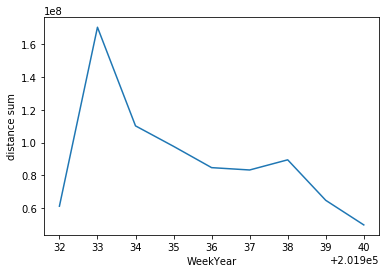

In [784]:
sns.lineplot(x='WeekYear',y='distance sum',data=weeklydist)
plt.show()

Although this is one training block, raising the weekly mileage directly after races with a strong taper the following weeks might prove beneficial as this had for me.

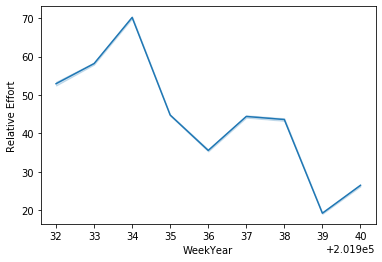

In [791]:
sns.lineplot(x='WeekYear',y='Relative Effort',data=trainingblockdf)
plt.show()

Relative Effort is a calculation done by Strava that estimates how hard the user is working based on their heart rate data. Theoretically, If your Relative Effort decreases with time, you are getting fitter. If we use Relative Effort in this sense, we see that for the most part, I was getting fitter through the eight weeks between races. Some peaks and valleys could be explained by hard workouts, followed by easy weeks.

<br>
So, since my RE got lower, this training block of a high mileage initially after, with a smooth taper seemed to have worked well for me.

## Day of the Week Analysis
#### Indepdence testing and analysis of which day of the week is best to run based on heart rate
One thing to note is that I usually take my off days on Mondays, so there will be significantly less data for those days which is shown in the facet grid below

In [646]:
dayofweeklist = rundf.IsoCalendar.apply(lambda x: x[2]).tolist() 
# day of week. Monday is 1 Sunday is 7

In [647]:
rundf['dayofweek'] = dayofweeklist

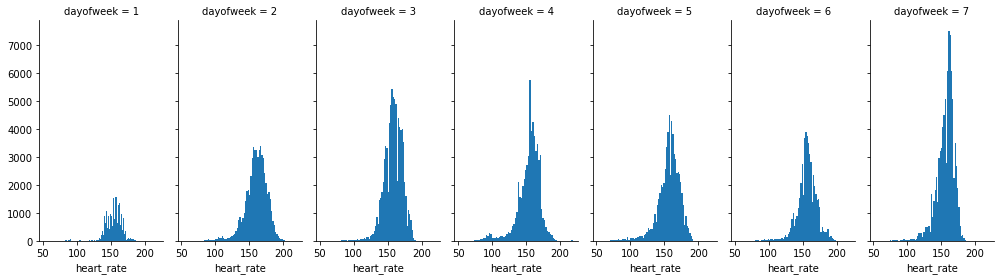

In [648]:
bins=75
g = sns.FacetGrid(rundf, col="dayofweek", height=4, aspect=0.5)
g = g.map(plt.hist, "heart_rate",bins=bins)

In [649]:
dowcont = pd.crosstab(rundf['dayofweek'],rundf['binnedHR'])
dowcont

binnedHR,45-99,100-139,140-159,160-179,180-200
dayofweek,,,,,
1,278,1189,11278,6322,217
2,377,4957,20347,26836,4771
3,334,6002,35691,36267,3327
4,1377,6810,26019,23605,1580
5,787,6737,26516,26524,2983
6,323,5071,25222,18259,2340
7,444,7456,35025,41275,515


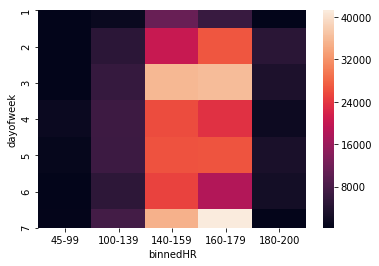

In [650]:
sns.heatmap(dowcont)

In [864]:
# observed table for day of week/HR. Neglect Mondays
f_obs2 = np.array([ 
                  dowcont.iloc[1][:].values,dowcont.iloc[2][:].values,dowcont.iloc[3][:].values,
                 dowcont.iloc[4][:].values,dowcont.iloc[5][:].values,dowcont.iloc[6][:]])

In [865]:
stats.chi2_contingency(f_obs2)[0:3]

(11213.06462251071, 0.0, 20)

So, day of the week is dependent on heart rate as we have a large chi squared value and a p val of 0. 

In [891]:
dowhr = rundf.groupby(by='dayofweek').agg({'heart_rate':['mean','median']})


Wednesdays have the lowest average heart rate, disregarding Mondays

In [892]:
dowhr.columns = [' '.join(col).strip() for col in dowhr.columns.values]

In [893]:
dowhr.reset_index(inplace=True)

In [894]:
dowhr.rename(columns={'heart_rate mean':'heart_rate'},inplace=True)

In [895]:
dowhrcut = dowhr[1:]

In [896]:
dowhrcut

,dayofweek,heart_rate,heart_rate median
1,2,159.852277,161.0
2,3,158.271303,159.0
3,4,154.333849,157.0
4,5,156.597542,159.0
5,6,156.379874,157.0
6,7,156.640418,159.0


In [900]:
dowhrcut['heart_rate'].mean()

157.01254380805258

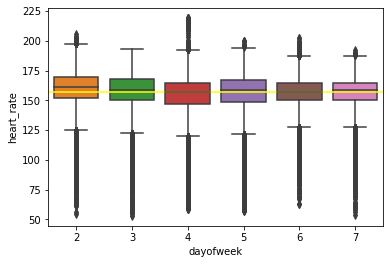

In [901]:
sns.boxplot(x='dayofweek',y='heart_rate',data=rundf)
plt.axhline(157.01,c='yellow')
plt.xlim(0.5,6.5)
plt.show()

Above is an interesting boxplot of the heart rate and day of the week. There seem to be a lot of outliers, but that is most likely due to the beginning of the file when I first begin running and get up to speed.

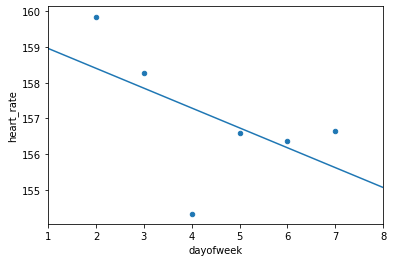

In [918]:
model = sm.OLS(dowhrcut.heart_rate, sm.add_constant(dowhrcut.dayofweek))
p = model.fit().params

x = np.arange(1, 9)

# scatter-plot data
ax = dowhrcut.plot(x='dayofweek', y='heart_rate', kind='scatter')

# plot regression line on the same axes, set x-axis limits
ax.plot(x, p.const + p.dayofweek * x)
ax.set_xlim([1, 8])
plt.show()

In [925]:
pearsonr(dowhrcut['dayofweek'],dowhrcut['heart_rate'])

(-0.5557280914091126, 0.2522216474362416)

We can conclude to reject the null hypothesis and say that there is significant evidence that the slope of our regression model is not 0. Our model fits fairly well, at -0.55. So this tells me as this is my data, that as the week progresses, my heart rate gets lower, thus more fit, regardless of when I do workouts with Wednesdays being the lowest average heart rate.

## Conclusion
This preliminary data analysis of Garmin running data extracted from Strava displays some interesting results that are found within the data that could not otherwise be seen on a running website such as Strava which provides basic analysis of runs. In addition, there is plenty more that can be done with this data that extends deeper using the path analysis and seasonal analysis that might prove interesting or useful.

<br>
Although this only covers data from my personal watch where I knew the runs and the routes, it could easily be extended to data that it unknown and continue to provide useful information to that person. In addition, this could be combined with data from the same area, say a xc team that runs similar routes, and use the path analysis to determine which routes seem to be the best for recovery, fitness, etc.

<br>

Through it all, I discovered some very interesting aspects that I can apply to my training, and will hopefully continue this project further.